# Arbolado IA
-------

### Paquetes
---

In [261]:
# General
import ast
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

# sklearn & XGB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost import XGBClassifier



# imbalanced-learn
from imblearn.over_sampling import SMOTE

# model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit

### Carga de datos
----

In [233]:
# Carga de datos
df = pd.read_csv('./data-arbolado-junior.csv')

In [234]:
print("El tamaño del DataFrame es: \n")
print(f'Shape: {df.shape}')

df.head()

El tamaño del DataFrame es: 

Shape: (3823, 28)


,id,fecha,latitud,longitud,direccion,barrioNombre,altura,fuste,faseVital,estadoFitosanitario,...,manejoInadecuado,intervenciones,distForestalAdecuada,interf,cazuela,levantamientoVereda,observaciones,especieNombre,lugarRelevamientoNombre,tipoLugarNombre
0,55216,7/2/2018,-31.418802,-64.170274,906,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,...,No,Mantenimiento,True,False,Inadecuada,Leve,NaN,Palmera Pindó,Americo Vespucio 900-1000,Calle
1,55217,7/2/2018,-31.418807,-64.170212,916,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Regular,...,Leve,Mantenimiento,True,True,Adecuada,Leve,NaN,Siempre Verde,Americo Vespucio 900-1000,Calle
2,55218,7/2/2018,-31.418807,-64.170161,924,Juniors,Menor a 4m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,...,Leve,Mantenimiento,True,False,Franja Verde,No,NaN,Crespón,Americo Vespucio 900-1000,Calle
3,55219,7/2/2018,-31.418832,-64.170114,930,Juniors,Entre 7m. y 10m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,...,Leve,Mantenimiento,True,False,Franja Verde,No,NaN,Guaran Amarillo,Americo Vespucio 900-1000,Calle
4,55220,7/2/2018,-31.418868,-64.169999,932,Juniors,Menor a 4m.,"Menor a 0,10m.",Maduro,Bueno,...,Leve,Mantenimiento,True,False,Franja Verde,No,NaN,Ficus Benjamina,Americo Vespucio 900-1000,Calle


## Ingeniería de Datos
----

In [235]:
cols_to_drop = [
    "id", "fecha", "latitud", "longitud", "direccion", 
    "barrioNombre", "observaciones", "lugarRelevamientoNombre", 
    "tipoLugarNombre"
]
df = df.drop(columns=cols_to_drop)

In [236]:
print(df.columns)

Index(['altura', 'fuste', 'faseVital', 'estadoFitosanitario', 'inclinacion',
       'ahuecamiento', 'problemaDesrames', 'problemaDescalzado',
       'problemaFustePartido', 'problemaObjetoExtranio', 'problemaGrieta',
       'problemaDesequilibrioCopa', 'manejoInadecuado', 'intervenciones',
       'distForestalAdecuada', 'interf', 'cazuela', 'levantamientoVereda',
       'especieNombre'],
      dtype='object')


### DataFrame discreto
---

In [237]:
filas_con_nan = df.isna().any(axis=1)

# Cantidad de filas con al menos un dato vacío
print(f"Filas con al menos un NaN: {filas_con_nan.sum()}")

# Filtrar esas filas
df = df[~df.isna().any(axis=1)].copy()

Filas con al menos un NaN: 445


In [238]:
label_maps = {}

le = LabelEncoder()

for col in df.columns:
    # Ignora columnas completamente vacías
    if df[col].dropna().empty:
        continue

    first_val = df[col].dropna().iloc[0]

    # Columnas booleanas (True/False)
    if isinstance(first_val, bool):
        df[col] = df[col].astype('boolean').fillna(False).astype(int)
    
    elif col == 'especieNombre' or col == 'cazuela':
        df[col] = le.fit_transform(df[col].astype(str))


In [239]:
# Diccionarios de remapeo
altura_map = {
    'Menor a 4m.': 0,
    'Entre 4m. y 7m.': 1,
    'Entre 7m. y 10m.': 2,
    'Mayor a 10m': 3
}

fuste_map = {
    'Menor a 0,10m.': 0,
    'Entre 0,10m. y 0,40m.': 1,
    'Mayor 0,40m': 2,
}

estadoFitosanitario_map = {
    'Bueno': 0,
    'Regular': 1,
    'Malo': 2,
    'Muerto': 3
}

leve_no_severa_map = {
    'No': 0,
    'Leve': 1,
    'Severa': 2
}

intervenciones_map = {
    'Sin intervenciones': 0,
    'Descopado': 1,
    'Despunte': 2,
    'Mantenimiento': 3,
    'Raíces': 4,
    'Tala': 5,
    'Varias intervenciones': 6
}

levantamientoVereda_map = {
    'No': 0,
    'Leve': 1,
    'Considerable': 2,
}

faseVital_map = {
    "Recién implantado": 0,
    "Joven": 1,
    "Maduro": 2,
    "Añoso": 3,
    "Decrépito": 4
}

# Aplicar remapeos en df
df['altura'] = df['altura'].map(altura_map)
df['fuste'] = df['fuste'].map(fuste_map)
df['estadoFitosanitario'] = df['estadoFitosanitario'].map(estadoFitosanitario_map)

# Columnas que comparten clasificación
for col in ['inclinacion', 'ahuecamiento', 'manejoInadecuado']:
    df[col] = df[col].map(leve_no_severa_map)

df['intervenciones'] = df['intervenciones'].map(intervenciones_map)
df['levantamientoVereda'] = df['levantamientoVereda'].map(levantamientoVereda_map)
df['faseVital'] = df['faseVital'].map(faseVital_map)

# Actualizar label_maps
label_maps.update({
    'altura': altura_map,
    'fuste': fuste_map,
    'estadoFitosanitario': estadoFitosanitario_map,
    'inclinacion': leve_no_severa_map,
    'ahuecamiento': leve_no_severa_map,
    'manejoInadecuado': leve_no_severa_map,
    'intervenciones': intervenciones_map,
    'levantamientoVereda': levantamientoVereda_map,
    'faseVital': faseVital_map
})


### DataFrame continuo
----

In [240]:
# Copiar el DataFrame original codificado
df_cont = df.copy()

# Quitar columna de especies
df_cont = df_cont.drop(columns=['especieNombre'])

# One-hot encoding solo de la columna especieNombre
# df_cont = pd.get_dummies(df_cont, columns=['especieNombre'])

# Inicializar el scaler
scaler = MinMaxScaler()

# Ajustar y transformar todas las columnas (o solo las que quieres escalar)
df_cont[df_cont.columns] = scaler.fit_transform(df_cont[df_cont.columns])

## Entrenamiento
----

### XGBoost - Regressor 
---

In [241]:
# Features (todas menos la columna objetivo)
X_XGB = df_cont.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea numérico)
y_XGB = df_cont["estadoFitosanitario"].astype(float)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_XGB, y_XGB, test_size=0.2, random_state=42
)

# Definir modelo XGBoost para regresión
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_reg.fit(X_train, y_train)

# Predecir
y_pred = xgb_reg.predict(X_test)

# Evaluar con métricas de regresión
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 0.14304880218618243
R²: 0.058731770291487795


faseVital                    0.140972
intervenciones               0.099398
problemaDescalzado           0.095353
problemaDesrames             0.078741
manejoInadecuado             0.077692
ahuecamiento                 0.068830
problemaFustePartido         0.047297
fuste                        0.045835
problemaGrieta               0.043449
problemaObjetoExtranio       0.041548
altura                       0.040985
interf                       0.040103
cazuela                      0.039077
distForestalAdecuada         0.037880
problemaDesequilibrioCopa    0.035577
levantamientoVereda          0.033985
inclinacion                  0.033278
dtype: float32


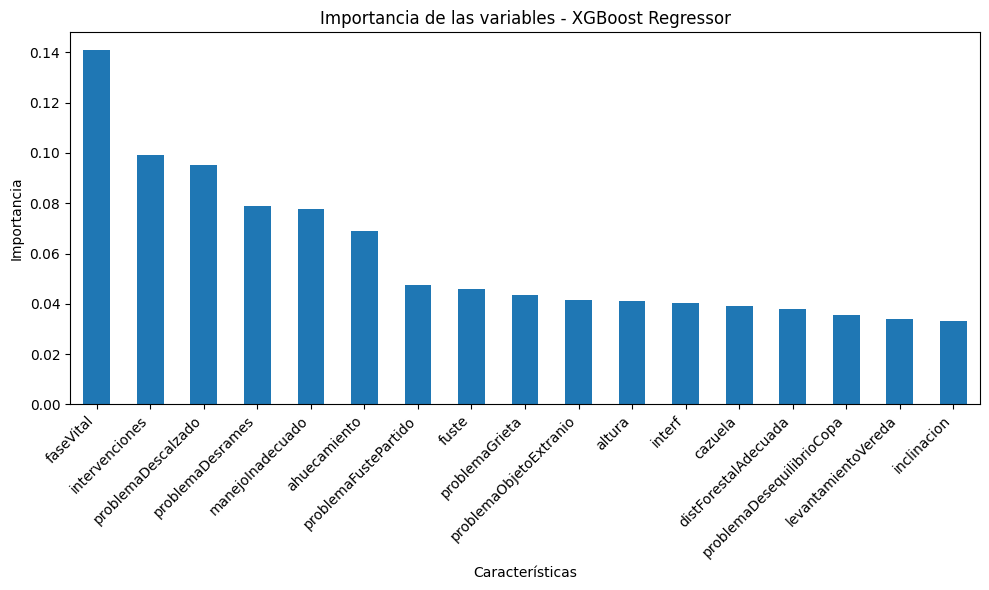

In [242]:
# Suponiendo que tu modelo se llama xgb_reg y tu DataFrame X
feature_importances = pd.Series(
    xgb_reg.feature_importances_,
    index=X_XGB.columns
).sort_values(ascending=False)

# Mostrar importancia
print(feature_importances)

# Gráfico de barras
plt.figure(figsize=(10,6))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables - XGBoost Regressor")
plt.ylabel("Importancia")
plt.xlabel("Características")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [245]:
# Lista de columnas a eliminar
cols_a_eliminar = ["cazuela", "problemaGrieta", "inclinacion", "distForestalAdecuada", "levantamientoVereda",  "problemaDesequilibrioCopa", "interf"]

# Crear un nuevo DataFrame solo con las columnas más importantes
df_reducido = df_cont.drop(columns=cols_a_eliminar)


In [246]:
# Features (todas menos la columna objetivo)
X = df_reducido.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea numérico)
y = df_reducido["estadoFitosanitario"].astype(float)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir modelo XGBoost para regresión
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_reg.fit(X_train, y_train)

# Predecir
y_pred = xgb_reg.predict(X_test)

# Evaluar con métricas de regresión
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 0.13456380832639095
R²: 0.16708345578748263


### XGBoost - Classifier
---

Accuracy: 0.7322485207100592

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.59      0.48        91
           1       0.89      0.78      0.83       546
           2       0.25      0.47      0.33        32
           3       0.25      0.29      0.27         7

    accuracy                           0.73       676
   macro avg       0.45      0.53      0.48       676
weighted avg       0.79      0.73      0.75       676



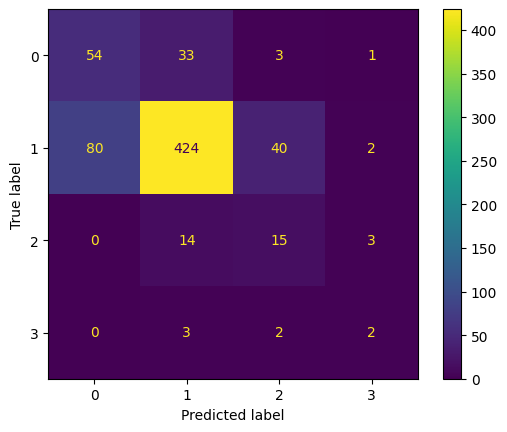

In [257]:
# Features (todas menos la columna objetivo)
X = df.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea entero)
y = df["estadoFitosanitario"].astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calcular pesos para cada clase
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Mapear cada muestra a su peso
sample_weights = y_train.map(class_weights)

# Definir modelo XGBoost para clasificación
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()


### Random Forest Regressor
---

In [247]:
X_rf = df_cont.drop("estadoFitosanitario", axis=1)
y_rf = df_cont["estadoFitosanitario"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(
    n_estimators=300,   # número de árboles
    max_depth=None,     # profundidad máxima de los árboles
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor")
print("RMSE:", rmse)
print("R²:", r2)

Random Forest Regressor
RMSE: 0.14340582921772832
R²: 0.05402739569095305


### Random Foresft - Classifier
---

Accuracy: 0.7928994082840237

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.36      0.42        91
           1       0.86      0.90      0.88       546
           2       0.30      0.28      0.29        32
           3       0.33      0.29      0.31         7

    accuracy                           0.79       676
   macro avg       0.50      0.46      0.47       676
weighted avg       0.78      0.79      0.78       676



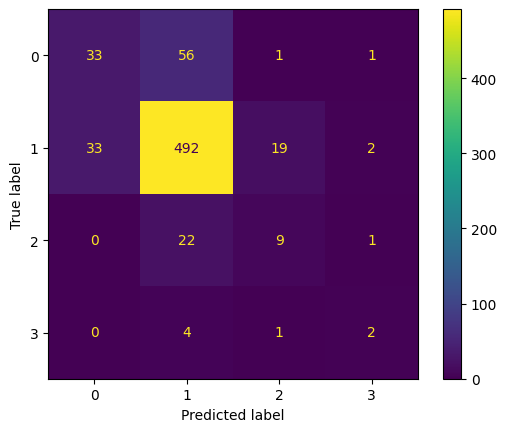

In [260]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train, y_train)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.7130177514792899

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.36      0.35        91
           1       0.85      0.80      0.82       546
           2       0.20      0.38      0.26        32
           3       0.22      0.29      0.25         7

    accuracy                           0.71       676
   macro avg       0.40      0.46      0.42       676
weighted avg       0.75      0.71      0.73       676



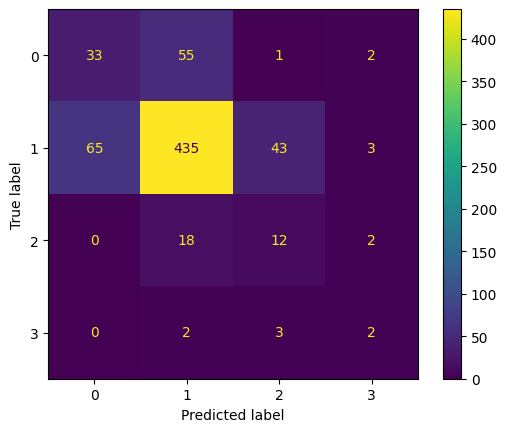

In [262]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train, y_train)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

## Prueba del modelo - Datos Artificiales
-----

In [66]:
# Features (todas menos la columna objetivo)
X = df1.drop("faseVital", axis=1)

# Target (asegurarse de que sea numérico)
y = df1["faseVital"].astype(float)

In [67]:
# Número de datos sintéticos que querés generar
n_samples = 100

synthetic_data = pd.DataFrame()

for col in X.columns:  # X = df1.drop("faseVital", axis=1)
    if X[col].dtype == float or X[col].dtype == int:
        # Generamos valores aleatorios normales con la misma media y desviación
        mu = X[col].mean()
        sigma = X[col].std()
        synthetic_data[col] = np.random.normal(mu, sigma, n_samples).round()
    else:
        # Para columnas categóricas, muestreamos los valores existentes
        synthetic_data[col] = np.random.choice(X[col], size=n_samples, replace=True)


### XGBoost
---

In [68]:
# Predecir usando el modelo XGBoost ya entrenado
y_pred_synthetic = xgb_reg.predict(synthetic_data)

# Si querés mapear a los valores discretos de faseVital (0–4):
y_pred_synthetic_rounded = np.clip(np.round(y_pred_synthetic), 0, 4).astype(int)

print(y_pred_synthetic_rounded)

[2 2 2 1 2 2 3 2 2 2 2 2 1 3 2 1 2 2 2 2 3 2 2 2 2 2 2 2 2 3 2 1 2 3 2 3 3
 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 1 1 3 2 2 2 2 2 4 2 2 2 3 2 2 2 2 2 2 2 2
 3 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [69]:
# Invertir el label map para faseVital
fase_map_invertido = {v: k for k, v in label_maps['faseVital'].items()}

# Iterar sobre las predicciones y mostrar el mensaje
for i, pred in enumerate(y_pred_synthetic_rounded, 1):  # empezamos la numeración en 1
    fase = fase_map_invertido[pred]
    print(f"La muestra {i} está en fase {fase}")


La muestra 1 está en fase Maduro
La muestra 2 está en fase Maduro
La muestra 3 está en fase Maduro
La muestra 4 está en fase Joven
La muestra 5 está en fase Maduro
La muestra 6 está en fase Maduro
La muestra 7 está en fase Añoso
La muestra 8 está en fase Maduro
La muestra 9 está en fase Maduro
La muestra 10 está en fase Maduro
La muestra 11 está en fase Maduro
La muestra 12 está en fase Maduro
La muestra 13 está en fase Joven
La muestra 14 está en fase Añoso
La muestra 15 está en fase Maduro
La muestra 16 está en fase Joven
La muestra 17 está en fase Maduro
La muestra 18 está en fase Maduro
La muestra 19 está en fase Maduro
La muestra 20 está en fase Maduro
La muestra 21 está en fase Añoso
La muestra 22 está en fase Maduro
La muestra 23 está en fase Maduro
La muestra 24 está en fase Maduro
La muestra 25 está en fase Maduro
La muestra 26 está en fase Maduro
La muestra 27 está en fase Maduro
La muestra 28 está en fase Maduro
La muestra 29 está en fase Maduro
La muestra 30 está en fase Añ